In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def initial_spins(L):
    return np.random.choice([1, -1], size=(L, L, L))

def aligned_spins(L):
    return np.ones((L, L, L))


def calculate_energy(spins, K, h, L):
    energy = 0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                energy -= h*spins[i, j, k]
                energy -= K*(spins[(i+1)%L, j, k] + spins[i, (j+1)%L, k] + spins[i, j, (k+1)%L])*spins[i, j, k]
    return energy


def calculate_M(spins, L):
    M = np.sum(spins)/(L**3)
    return M


def calculate_C(total_E, total_E_squared, mcs):
    # 1/T^2 (<E^2> - <E>^2)
    avg_E = total_E/mcs
    avg_E_squared = total_E_squared/mcs
    C = T**(-2)*(avg_E_squared - avg_E**2)
    return C/(L**3)


def calculate_sus(total_M, total_M_squared, mcs):
    # 1/T (<M^2> - <M>^2)
    avg_M = total_M/mcs
    avg_M_squared = total_M_squared/mcs
    sus = T**(-1)*(avg_M_squared - avg_M**2)
    return sus/(L**3)


def calculate_correlation_length(spins):
    # TODO
    corr_len = 0
    return corr_len



In [2]:
def metropolis_algorithim(spins, T, K, h, L):
    # compute beta
    beta = 1/T
    
    #making a trial flip
    i, j, k = np.random.randint(0, L, size=3)
    site = spins[i, j, k]
    trial_flip = site * -1
    trial_flip_spins = spins.copy()
    trial_flip_spins[i, j, k] = trial_flip

    #calculating old energy
    old_energy = -h*spins[i, j, k] - K*(spins[(i+1)%L, j, k] + spins[i, (j+1)%L, k] + spins[i, j, (k+1)%L] +
                                     spins[(i - 1) % L, j, k] +  spins[i, (j-1)%L, k] + spins[i, j, (k-1)%L])*spins[i, j, k]
    #calculating new energy
    new_energy = -h*trial_flip_spins[i, j, k]
    new_energy -= K*(trial_flip_spins[(i+1)%L, j, k] + trial_flip_spins[i, (j+1)%L, k] + trial_flip_spins[i, j, (k+1)%L] +
                                      trial_flip_spins[(i - 1) % L, j, k] +  trial_flip_spins[i, (j-1)%L, k]
                                       + trial_flip_spins[i, j, (k-1)%L])*trial_flip_spins[i, j, k]
    #computing delta E and deciding if we should accept the change
    delta_energy = new_energy - old_energy
    if delta_energy <= 0:
        spins[i, j, k] = trial_flip
    else:
        w = np.exp(-beta*delta_energy)
        r = random.random()
        if r <= w:
            spins[i, j, k] = trial_flip
    return(spins)

def monte_carlo(T, K, h, L, steps, spins):
    mcs = 1
    total_E = 0
    total_E_squared = 0
    total_M = 0
    total_M_squared = 0

    energies = [calculate_energy(spins, K, h, L)]
    magnetizations = [calculate_M(spins, L)]
    specific_heats = [calculate_C(total_E, total_E_squared, mcs)]
    susceptibilities = [calculate_sus(total_M, total_M_squared, mcs)]
    correlations = [calculate_correlation_length(spins)]

    for step in range(steps):
        spins = metropolis_algorithim(spins, T, K, h, L)
        if step % 100 == 0 or step == steps-1:
            mcs += 1
            energy = calculate_energy(spins, K, h, L)
            total_E += energy
            total_E_squared += energy**2

            mag = calculate_M(spins, L)
            total_M += mag
            total_M_squared += mag**2
            
            energies.append(energy)
            magnetizations.append(mag)
            specific_heats.append(calculate_C(total_E, total_E_squared, mcs))
            susceptibilities.append(calculate_sus(total_M, total_M_squared, mcs))
            correlations.append(calculate_correlation_length(spins))

    return spins, (energies, magnetizations, specific_heats, susceptibilities, correlations)

In [3]:
def scatter_3D(data, ax, title):
    x = np.indices(data.shape)[0]
    y = np.indices(data.shape)[1]
    z = np.indices(data.shape)[2]
    col = data.flatten()
    
    # 3D Plot
    p3d = ax.scatter(x, y, z, c=col, cmap="PiYG", vmin=-1, vmax=1)
    ax.grid(False)
    plt.colorbar(p3d, label="Spin")
    ax.set_title(title)
    return

In [4]:
def normalize(array):
    normalized_array = array.copy()
    max = np.max(array)
    min = np.min(array)
    for i in range(len(array)):
        normalized_array[i] = (array[i] - min)/(max-min)
    return normalized_array

def difference(array):
    differences = array.copy()[:-1]
    for i in range(len(array)-1):
        differences[i] = array[i+1] - array[i]
    return differences

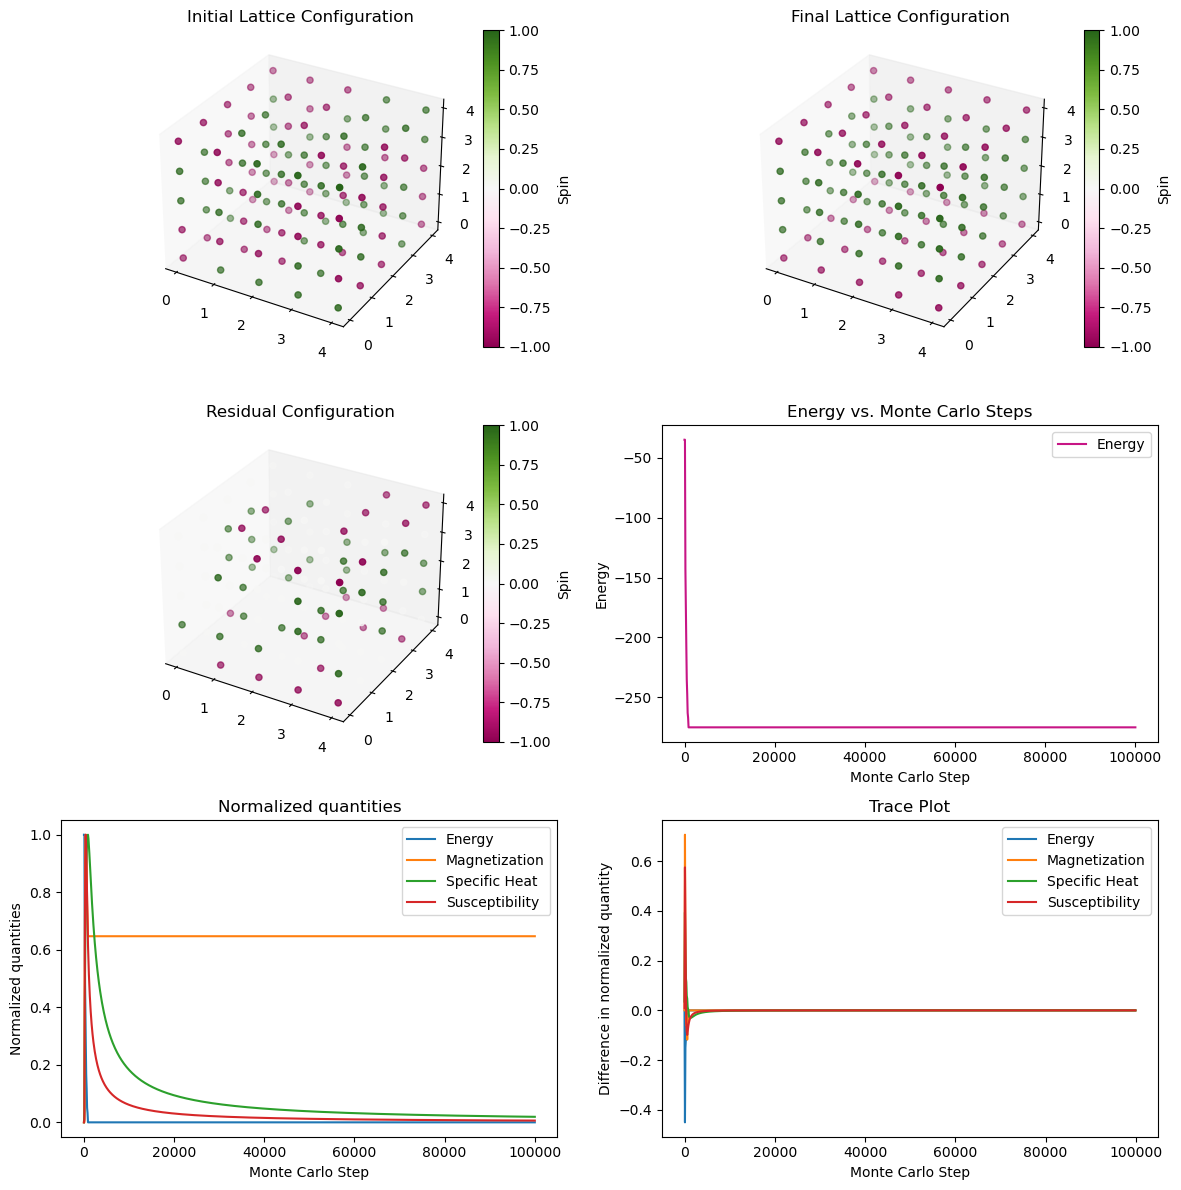

In [5]:
T = 10**(-5)
K = 1
h = 0
L = 5
steps = 100000

spins_initial = initial_spins(L)
copy_of_spins_initial = spins_initial.copy()
final_spins, quantities = monte_carlo(T, K, h, L, steps, spins_initial)

# Visualization
cmap = "PiYG"
fig = plt.figure(figsize=(12, 12))

ax0 = fig.add_subplot(3, 2, 1, projection='3d')
scatter_3D(copy_of_spins_initial, ax0, "Initial Lattice Configuration")

ax1 = plt.subplot(3, 2, 2, projection='3d')
scatter_3D(final_spins, ax1, "Final Lattice Configuration")

ax2 = plt.subplot(3, 2, 3, projection='3d')
scatter_3D(final_spins - copy_of_spins_initial, ax2, "Residual Configuration")

energies = quantities[0]
plt.subplot(3, 2, 4)
plt.title("Energy vs. Monte Carlo Steps")
plt.plot(range(0, len(energies) * 100, 100), energies, label="Energy", color='mediumvioletred')
plt.xlabel("Monte Carlo Step")
plt.ylabel("Energy")
plt.legend()

plt.subplot(3, 2, 5)
plt.title("Normalized quantities")
xs = np.linspace(0, steps, len(quantities[0]))
plt.plot(xs, normalize(quantities[0]), label="Energy")
plt.plot(xs, normalize(quantities[1]), label="Magnetization")
plt.plot(xs, normalize(quantities[2]), label="Specific Heat")
plt.plot(xs, normalize(quantities[3]), label="Susceptibility")
# plt.plot(xs, normalize(quantities[4]), label="Correlation Length")  # TODO
plt.xlabel("Monte Carlo Step")
plt.ylabel("Normalized quantities")
plt.legend()

plt.subplot(3, 2, 6)
plt.title("Trace Plot")
plt.plot(xs[:-1], difference(normalize(quantities[0])), label="Energy")
plt.plot(xs[:-1], difference(normalize(quantities[1])), label="Magnetization")
plt.plot(xs[:-1], difference(normalize(quantities[2])), label="Specific Heat")
plt.plot(xs[:-1], difference(normalize(quantities[3])), label="Susceptibility")
# plt.plot(xs[:-1], difference(quantities[4]), label="Correlation Length")  # TODO
plt.xlabel("Monte Carlo Step")
plt.ylabel("Difference in normalized quantity")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

In [6]:
def plot_final_vs_t(temps, final_vals, axs, name, L):
    axs.scatter(temps, final_vals, label=str(L))
    axs.axvline(x=4.5108, color='hotpink')
    axs.set_xlabel("Temp")
    axs.set_ylabel(name)
    axs.legend()
    return axs

100%|███████████████████████████████████████████████████| 100/100 [04:39<00:00,  2.80s/it]


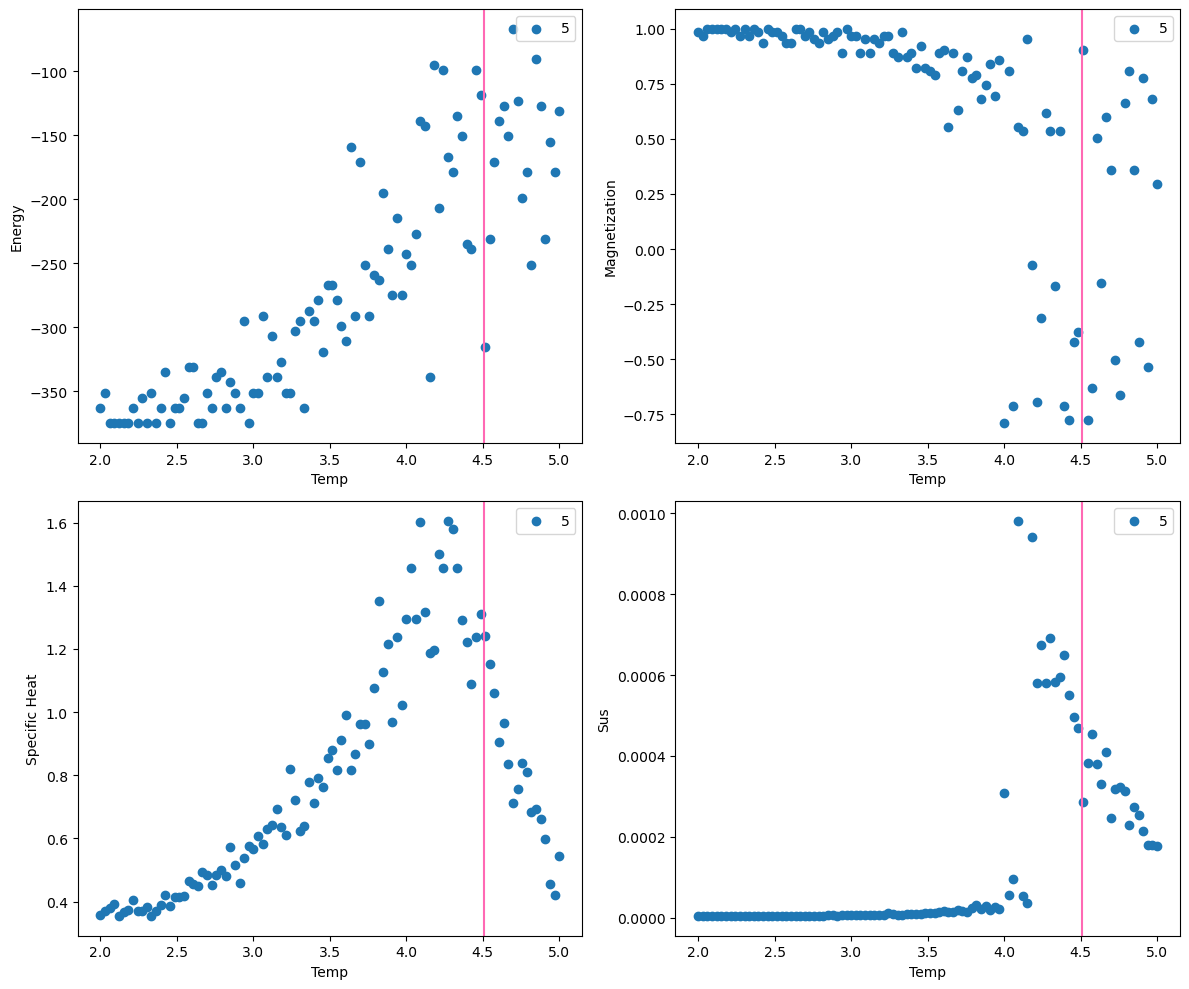

In [7]:
spins_aligned = aligned_spins(L)
temps = np.linspace(2, 5, 100)
final_Es = []
final_Ms = []
final_Cs = []
final_chis = []
final_xis = []

# turn off external magnetic field
K = 1
h = 0
L = 5
steps = 100000

for T in tqdm(temps):
    aligned_spins_initial = spins_aligned.copy()
    _, quantities = monte_carlo(T, K, h, L, steps, aligned_spins_initial)
    final_Es.append(quantities[0][-1])
    final_Ms.append(quantities[1][-1])
    final_Cs.append(quantities[2][-1])
    final_chis.append(quantities[3][-1])
    final_xis.append(quantities[4][-1])

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0] = plot_final_vs_t(temps, final_Es, ax[0, 0], "Energy", L)
ax[0, 1] = plot_final_vs_t(temps, final_Ms, ax[0, 1], "Magnetization", L)
ax[1, 0] = plot_final_vs_t(temps, final_Cs, ax[1, 0], "Specific Heat", L)
ax[1, 1] = plot_final_vs_t(temps, final_chis, ax[1, 1], "Sus", L)
# ax[2, 0] = plot_final_vs_t(temps, final_xis, ax[2, 0], "Correlation Length")

plt.tight_layout()
plt.show()
plt.close()

100%|███████████████████████████████████████████████████| 200/200 [03:56<00:00,  1.18s/it]


[4.071356783919597, 4.109547738693467, 4.205025125628141, 4.796984924623116]
[1.1569430758812653, 2.0715597733829503, 3.2762012279189103, 6.48226998592616]


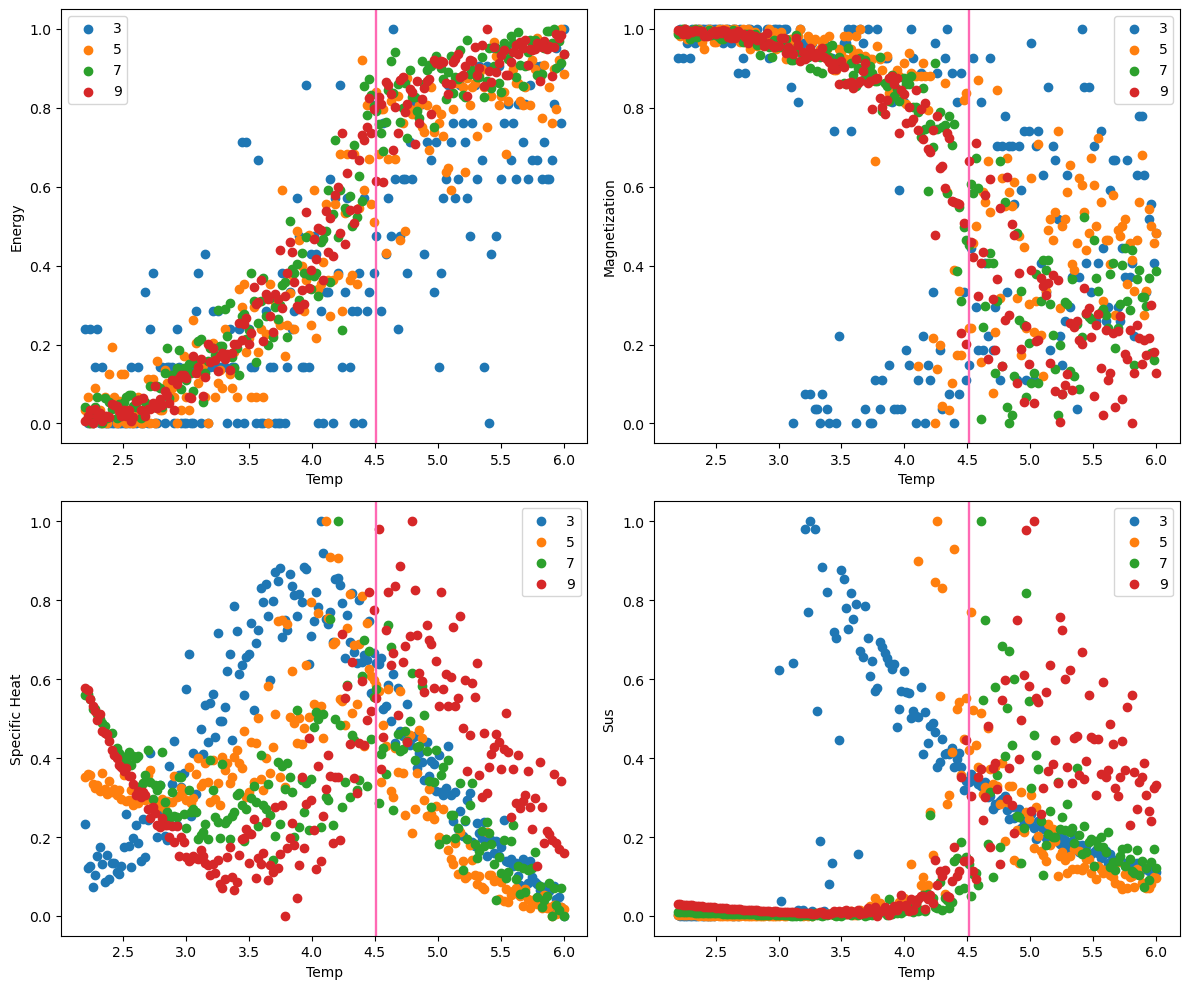

In [8]:
steps = 30000
max_Cs = []
max_suss = []
T_cs = []

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

Ls = [3, 5, 7, 9]
for L in Ls:
    # turn off external magnetic field
    h = 0

    spins_aligned = aligned_spins(L)
    temps = np.linspace(2.2, 6, 200)
    final_Es = []
    final_Ms = []
    final_Cs = []
    final_chis = []
    final_xis = []

    for T in tqdm(temps):
        aligned_spins_initial = spins_aligned.copy()
        _, quantities = monte_carlo(T, K, h, L, steps, aligned_spins_initial)
        final_Es.append(quantities[0][-1])
        final_Ms.append(quantities[1][-1])
        final_Cs.append(quantities[2][-1])
        final_chis.append(quantities[3][-1])
        final_xis.append(quantities[4][-1])

    max_Cs.append(np.max(final_Cs))
    max_suss.append(np.max(final_chis))
    T_cs.append(temps[np.argmax(final_Cs)])
    
    ax[0, 0] = plot_final_vs_t(temps, normalize(final_Es), ax[0, 0], "Energy", L)
    ax[0, 1] = plot_final_vs_t(temps, normalize(final_Ms), ax[0, 1], "Magnetization", L)
    ax[1, 0] = plot_final_vs_t(temps, normalize(final_Cs), ax[1, 0], "Specific Heat", L)
    ax[1, 1] = plot_final_vs_t(temps, normalize(final_chis), ax[1, 1], "Sus", L)

print(T_cs)
print(max_Cs)

plt.tight_layout()
plt.show()
plt.close()

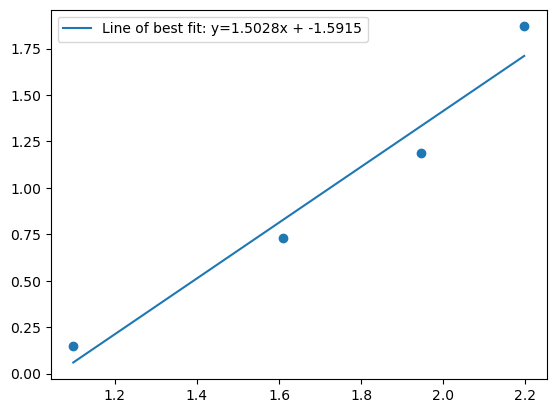

In [9]:
x = np.log(Ls)
y= np.log(max_Cs)

coeffs = np.polyfit(x, y, 1)

plt.scatter(x, y)
plt.plot(x, coeffs[0]*x + coeffs[1], label=f"Line of best fit: y={round(coeffs[0], 4)}x + {round(coeffs[1], 4)}")
plt.legend()

plt.show()
plt.close()

In [11]:
#expected slope:
.11/.63

0.1746031746031746